# 앙상블 모델(Boosting 알고리즘)로 직원 이직 여부 예측하기

## 라이브러리 임포트

In [11]:
# 필요한 라이브러리 불러오기
import numpy as np  # 수치 연산을 위한 NumPy
import pandas as pd  # 데이터프레임 처리를 위한 Pandas

from sklearn.ensemble import GradientBoostingClassifier  # GBM 분류기
from sklearn.metrics import accuracy_score, classification_report, log_loss  # 성능 평가 지표
from sklearn.model_selection import train_test_split, GridSearchCV  # 데이터 분할 및 하이퍼파라미터 탐색

## 데이터 로드 및 기초 확인

In [12]:
attrition = pd.read_csv(
    'https://raw.githubusercontent.com/aettikang/bigdata_analysis_basic/main/HR-Employee-Attrition.csv'
)
attrition.head()  # 처음 5개 행 출력
attrition.info()  # 컬럼별 데이터 타입 및 결측치 정보 확인


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   BusinessTravel            1470 non-null   object
 2   DailyRate                 1470 non-null   int64 
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   HourlyRate                1470 non-null   int64 
 10  JobInvolvement            1470 non-null   int64 
 11  JobLevel                  1470 non-null   int64 
 12  JobRole                   1470 non-null   object
 13  JobSatisfaction           1470 non-null   int64 
 14  MaritalStatus           

##  범주형 변수를 더미(One-Hot) 인코딩

In [13]:
attrition_dummies = pd.get_dummies(attrition)
feature_cols = list(attrition_dummies.columns.difference(['Attrition']))  # 타겟인 Attrition 제외
X = attrition_dummies[feature_cols]  # 입력 변수
y = attrition_dummies['Attrition'].astype('category')  # 타겟 변수

## 학습용/테스트용 데이터 분할

In [14]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y,
    train_size=0.80,  # 80% 학습, 20% 테스트
    random_state=0     # 재현성을 위한 시드 고정
)

## 하이퍼파라미터 그리드 설정 및 탐색

In [15]:
param_grid = {
    'n_estimators': [1000, 1500],     # 트리 개수
    'max_depth': [4, 6],              # 최대 트리 깊이
    'min_samples_leaf': [2, 4],       # 리프 노드 최소 샘플 수
    'max_features': [0.7, 0.9],       # 피처 샘플링 비율
    'learning_rate': [0.25, 0.3]      # 학습률
}

gbm = GradientBoostingClassifier(random_state=0)
grid_cv = GridSearchCV(
    gbm,
    param_grid=param_grid,
    cv=3,         # 3-겹 교차검증
    n_jobs=-1,    # 모든 CPU 코어 활용
    refit=True    # 최적 모델로 자동 재학습
)
grid_cv.fit(train_X, train_y)  # 학습 및 검증

print('최적 하이퍼파라미터:', grid_cv.best_params_)
print('교차검증 최고 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼파라미터: {'learning_rate': 0.3, 'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 2, 'n_estimators': 1000}
교차검증 최고 정확도: 0.8622


## 최종 모델 학습·예측·평가

In [16]:
best_model = grid_cv.best_estimator_  # refit된 최적 모델
preds = best_model.predict(test_X)  # 클래스 예측
preds_proba = best_model.predict_proba(test_X)[:, 1]  # 양성(Attrition=1) 확률

print('테스트 정확도: {:.4f}'.format(accuracy_score(test_y, preds)))
print('로그 손실(Log Loss): {:.4f}'.format(log_loss(test_y.cat.codes, preds_proba)))
print('\n분류 리포트:')
print(classification_report(test_y, preds))



테스트 정확도: 0.8503
로그 손실(Log Loss): 1.5945

분류 리포트:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       245
           1       0.60      0.31      0.41        49

    accuracy                           0.85       294
   macro avg       0.74      0.63      0.66       294
weighted avg       0.83      0.85      0.83       294



## 변수 중요도 확인 및 시각화

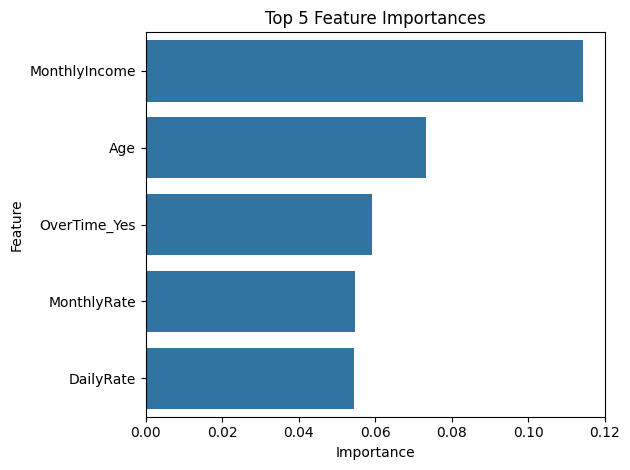

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(5)

# Jupyter magic 대신 plt.show() 사용
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Top 5 Feature Importances')
plt.tight_layout()
plt.show()  # 플롯을 표시
